In [1]:
import numpy as np
import pandas as pd
import bioframe as bf
import seaborn as sns
import matplotlib.pyplot as plt
from akita_utils.df_utils import filter_by_chromID
from helper import read_tad_disruption_data
from skimage.filters import threshold_li
from scipy.interpolate import make_interp_spline
from scipy.ndimage import gaussian_filter1d

In [2]:
df = read_tad_disruption_data()

In [3]:
# order of disrupted bins from downstream to upstream
type_order = [f"down{i}" for i in range(20,0,-1)] + [f"tad{i}" for i in range(1,6)] + [f"up{i}" for i in range(1,21)]

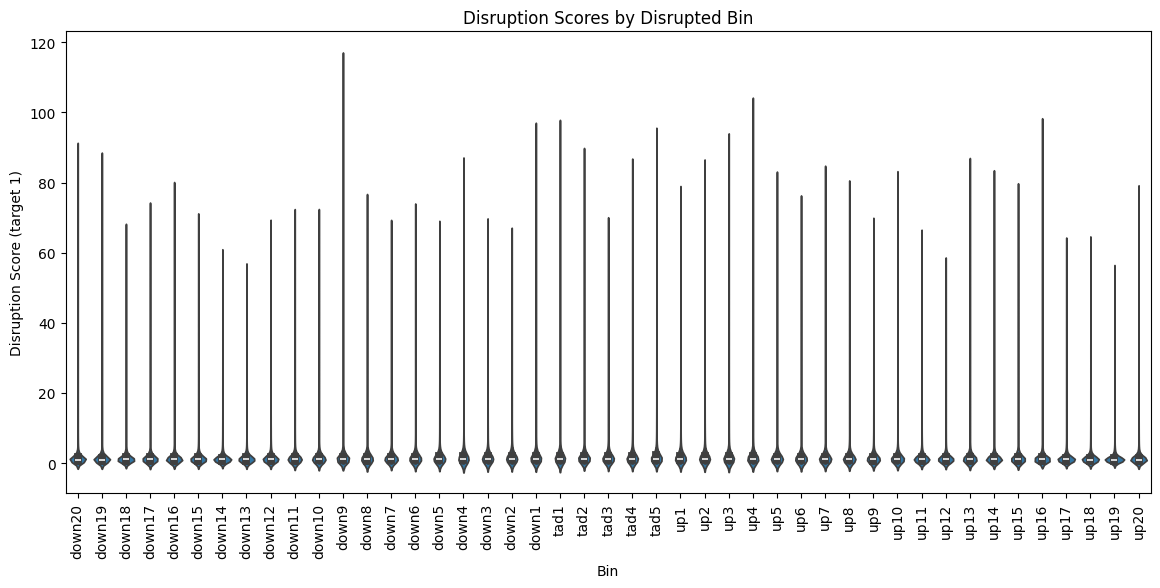

In [4]:
# Set up the figure
plt.figure(figsize=(14, 6))

# Create the violin plot
sns.violinplot(data=df, x='type', y='SCD_h1_m0_t1', inner='box', order=type_order)
# target 1 is Bonev ES Cells, which HiC TAD boundaries have called on

# Add labels and title
plt.xlabel('Bin')
plt.ylabel('Disruption Score (target 1)')
plt.title('Disruption Scores by Disrupted Bin')
plt.xticks(rotation=90)

# Show the plot
plt.show()

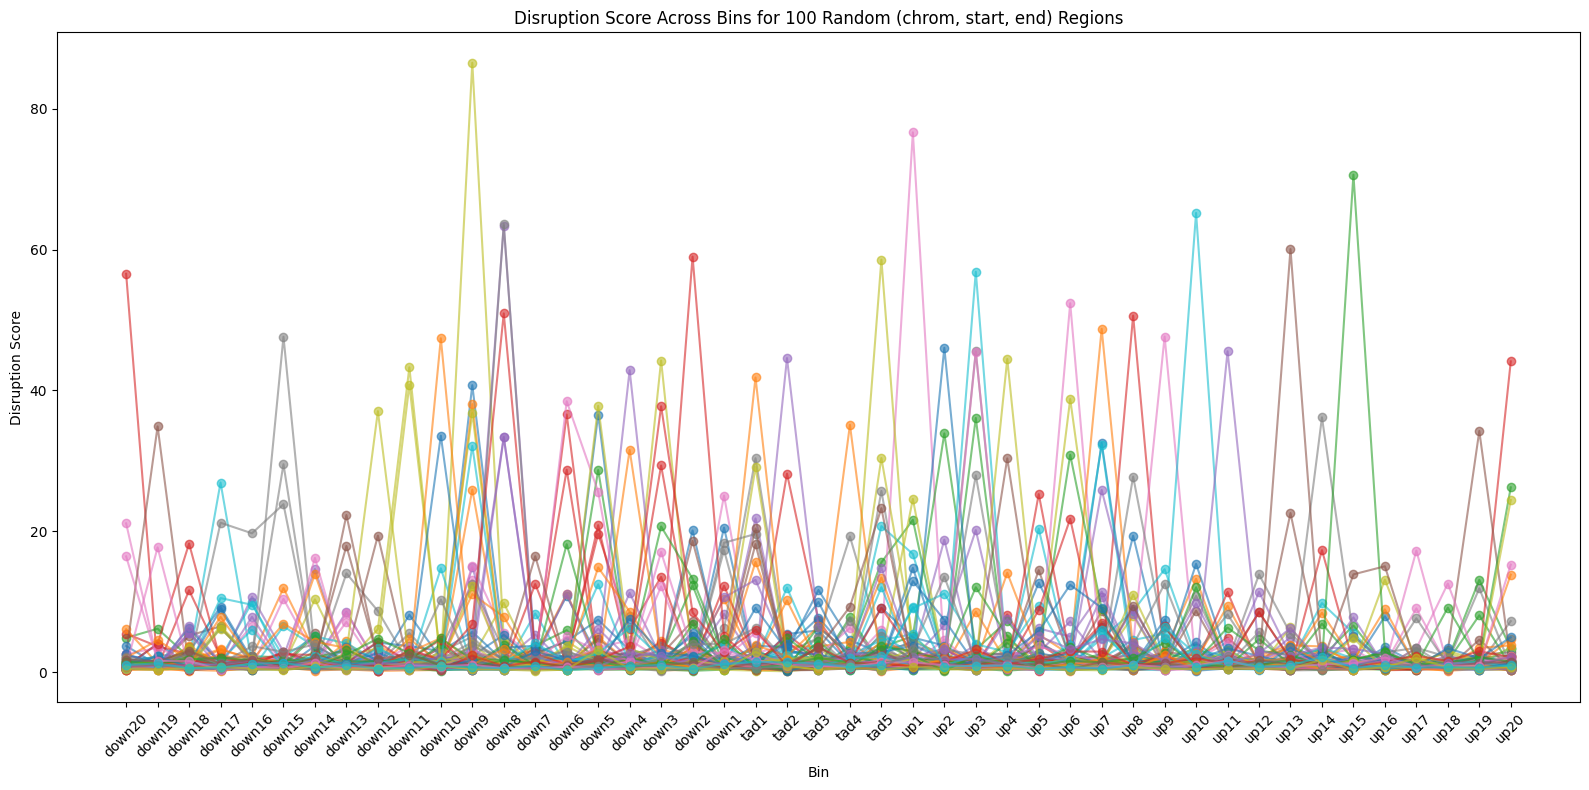

In [5]:
# Randomly sample 100 unique (chrom, start, end) regions
sampled_df = df.drop_duplicates(subset=['chrom', 'start', 'end']).sample(n=100)

# Filter the original dataframe to include only the sampled regions
filtered_df = df[df[['chrom', 'start', 'end']].apply(tuple, axis=1).isin(sampled_df[['chrom', 'start', 'end']].apply(tuple, axis=1))]

# Set up the figure
plt.figure(figsize=(16, 8))

# Create a mapping from type to order
type_mapping = {t: i for i, t in enumerate(type_order)}

# For each sampled region, plot the line connecting SCD values for each type
for (chrom, start, end), group in filtered_df.groupby(['chrom', 'start', 'end']):
    # Sort the group by the defined type order
    group = group.sort_values(by='type', key=lambda x: x.map(type_mapping))
    plt.plot(group['type'], group['SCD_h1_m0_t1'], marker='o', label=f"{chrom}:{start}-{end}", alpha=0.6)

# Add labels and title
plt.xlabel('Bin')
plt.ylabel('Disruption Score')
plt.title('Disruption Score Across Bins for 100 Random (chrom, start, end) Regions')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

### Checking for orientation assymetry

In [6]:
# Excluding boundaries with no disruption-sensitive bins
filtered_df = df[df['SCD_h1_m0_t1'] >= 18.705717] # Li threshold (calculated below)

# selecting one bin for a boundary resulting in the highest disruption score
max_SCD_df = filtered_df.groupby(['chrom', 'start', 'end', 'type', 
                                  'rel_disruption_end', 'rel_disruption_start',
                                  'window_end', 'window_start'])["SCD_h1_m0_t1"].max().reset_index()

max_indices = max_SCD_df.groupby(['chrom', 'start', 'end'])['SCD_h1_m0_t1'].idxmax()
unique_max_scd_df = max_SCD_df.loc[max_indices].reset_index(drop=True)

In [7]:
# renaming to overlap with jaspar set of CTCFs
unique_max_scd_df_rn = unique_max_scd_df.rename(columns={"start": "TAD_start", "end": "TAD_end"})
unique_max_scd_df_rn["start"] = unique_max_scd_df_rn["window_start"] + unique_max_scd_df_rn["rel_disruption_start"]
unique_max_scd_df_rn["end"] = unique_max_scd_df_rn["window_start"] + unique_max_scd_df_rn["rel_disruption_end"]

In [8]:
# loading JASPAR CTCF dataset
jaspar_file = "/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz"
chrom_sizes_file = "/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced"
autosomes_only = True

if autosomes_only:
    chromID_to_drop = ["chrX", "chrY", "chrM"]
    
# read jaspar table (all CTCFs in the mouse genome)
jaspar_df = bf.read_table(jaspar_file, schema="jaspar", skiprows=1)
if autosomes_only:
    jaspar_df = filter_by_chromID(jaspar_df, chrID_to_drop=chromID_to_drop)
jaspar_df.reset_index(drop=True, inplace=True)

In [9]:
# overlapping with CTCF sites from JASPAR database
orient_df_overlap = bf.overlap(unique_max_scd_df_rn, jaspar_df, suffixes=("", "_2"), return_index=False, how="inner")
orient_df_overlap['strand_2'] = orient_df_overlap['strand_2'].replace({'+': '>', '-': '<'})

overlap_strand = orient_df_overlap.groupby(['chrom', 'start', 'end', 'type']).agg({
    'strand_2': lambda x: ''.join(x),   # Concatenate 'type' values
}).reset_index()

In [10]:
# assigning orientation
def classify_strand(strand):
    if '>' in strand and '<' not in strand:
        return 'right'
    elif '<' in strand and '>' not in strand:
        return 'left'
    else:
        return 'other'

In [11]:
# Apply the classification to the strand_2 column
overlap_strand['orientation'] = overlap_strand['strand_2'].apply(classify_strand)

# Group by type and orientation, and count occurrences
grouped_counts = overlap_strand.groupby(['type', 'orientation']).size().unstack(fill_value=0)

# Reindex the DataFrame to ensure the correct order of types
grouped_counts = grouped_counts.reindex(type_order)

In [12]:
# translating bins' labels into relative coordinates
type_num_values = [-45.1, -43.0, -41.0, -38.9, -36.9, -34.8, -32.8, -30.7, -28.7, -26.6, 
               -24.6, -22.5, -20.5, -18.4, -16.4, -14.3, -12.3, -10.2, -8.2, -6.1, 
               -4.1, -2.0, 0.0, +2.0, +4.1, +6.1, +8.2, +10.2, +12.3, +14.3, 
               +16.4, +18.4, +20.5, +22.5, +24.6, +26.6, +28.7, +30.7, +32.8, +34.8, 
               +36.9, +38.9, +41.0, +43.0, +45.1]

In [13]:
type_to_num = dict(zip(type_order, type_num_values))
overlap_strand['type_numeric'] = overlap_strand['type'].map(type_to_num)

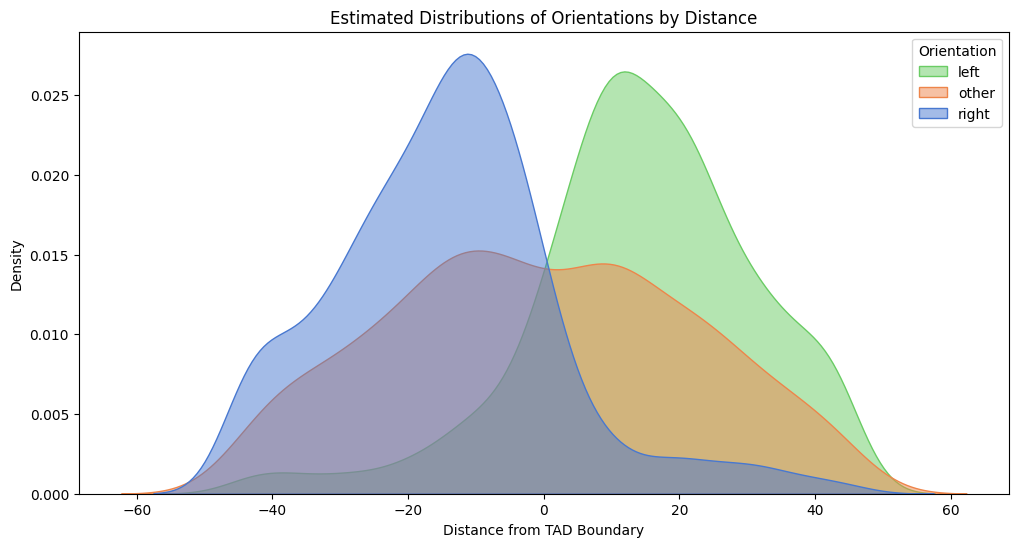

In [14]:
# Plotting estimated distributions with filled KDE and custom legend labels
plt.figure(figsize=(12, 6))
sns.kdeplot(data=overlap_strand, x='type_numeric', hue='orientation', fill=True, common_norm=False, 
            palette="muted", alpha=0.5)

plt.xlabel("Distance from TAD Boundary")
plt.ylabel("Density")
plt.title("Estimated Distributions of Orientations by Distance")

# Customize the legend labels
legend_labels = {'left': 'Left-Oriented', 'other': 'Other Orientation', 'right': 'Right-Oriented'}
plt.legend(labels=legend_labels, title="Orientation")

plt.show()

In [15]:
type_labels = ["-45.1", "-43.0", "-41.0", "-38.9", "-36.9", "-34.8", "-32.8", "-30.7", "-28.7", "-26.6", 
               "-24.6", "-22.5", "-20.5", "-18.4", "-16.4", "-14.3", "-12.3", "-10.2", "-8.2", "-6.1", 
               "-4.1", "-2.0", "0.0", "2.0", "4.1", "6.1", "8.2", "10.2", "12.3", "14.3", 
               "16.4", "18.4", "20.5", "22.5", "24.6", "26.6", "28.7", "30.7", "32.8", "34.8", 
               "36.9", "38.9", "41.0", "43.0", "45.1"]

In [16]:
total = grouped_counts.sum(axis=1)

<Figure size 2000x1000 with 0 Axes>

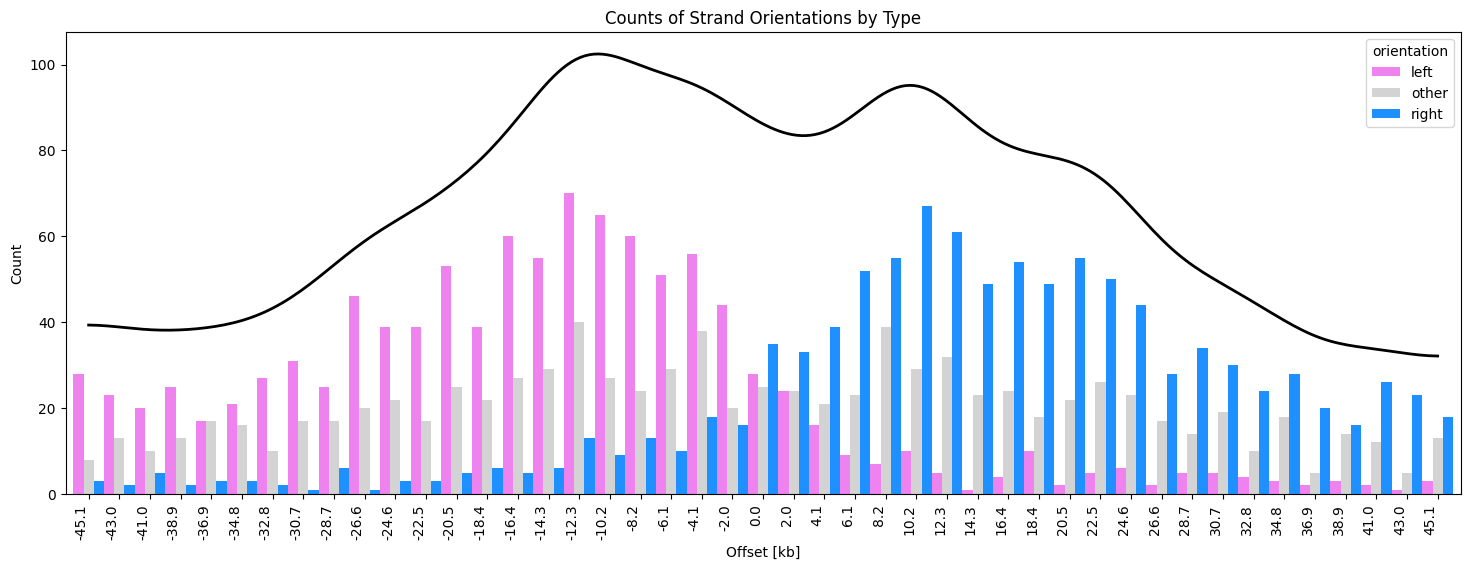

In [17]:
# Create the bar plot
plt.figure(figsize=(20,10))
grouped_counts.plot(kind='bar', stacked=False, color=['violet', 'lightgray', 'dodgerblue'], width=1, figsize=(18, 6))

# Generate a smooth x-axis range
x = np.arange(len(grouped_counts.index))
x_smooth = np.linspace(x.min(), x.max(), 300)  # Increase the resolution for smoothness

# Perform cubic spline interpolation for the total line
spline = make_interp_spline(x, total, k=5)
y_smooth = spline(x_smooth)

# Apply Gaussian filter for additional smoothing
y_smooth = gaussian_filter1d(y_smooth, sigma=10)

plt.plot(x_smooth, y_smooth, color='black', linestyle='-', linewidth=2, label='Smoothed Total Count')

# Customize plot
plt.title('Counts of Strand Orientations by Type')
plt.xlabel('Offset [kb]')
plt.ylabel('Count')
plt.xticks(ticks=range(len(type_labels)), labels=type_labels, rotation=90, ha='right')

# plt.savefig("./plots/orientation_insulation_offset.pdf", format="pdf")

# Show the plot
plt.show()

In [ ]:
# As the number of assymetric orientation is stabilized down- and upstream +-28kb, 
# we take into account the disruptions within +-28kb (precisely, 28.7kb) to classify TAD boundaries as the ones we can and cannot explain by this experiment.

### Checking the TAD boundary metrics (from the HiC data)

In [18]:
scores_df = pd.read_csv("./../input_data/TAD_boundaries/all_boundaries.tsv", sep="\t")

In [19]:
overlapped_df = bf.overlap(df, scores_df, suffixes=("", "_2"), return_index=False, how="left")
max_scd_overlapped_df = overlapped_df.groupby(by=["chrom", "start", "end"])["SCD_h1_m0_t1"].max().reset_index()
mean_ins = overlapped_df.groupby(by=["chrom", "start", "end"])[["log2_insulation_score_200000_2", "n_valid_pixels_200000_2", "boundary_strength_200000_2"]].mean().reset_index()

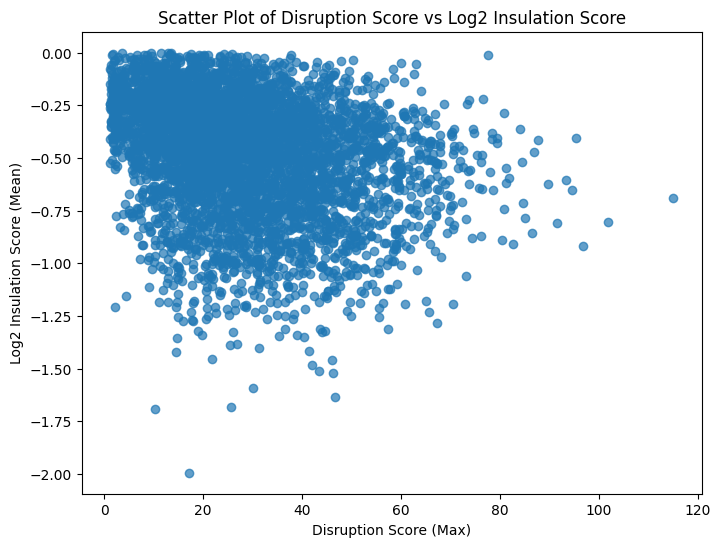

In [20]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_overlapped_df["SCD_h1_m0_t1"], mean_ins["log2_insulation_score_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('Disruption Score (Max)')
plt.ylabel('Log2 Insulation Score (Mean)')
plt.title('Scatter Plot of Disruption Score vs Log2 Insulation Score')

# Show the plot
plt.show()

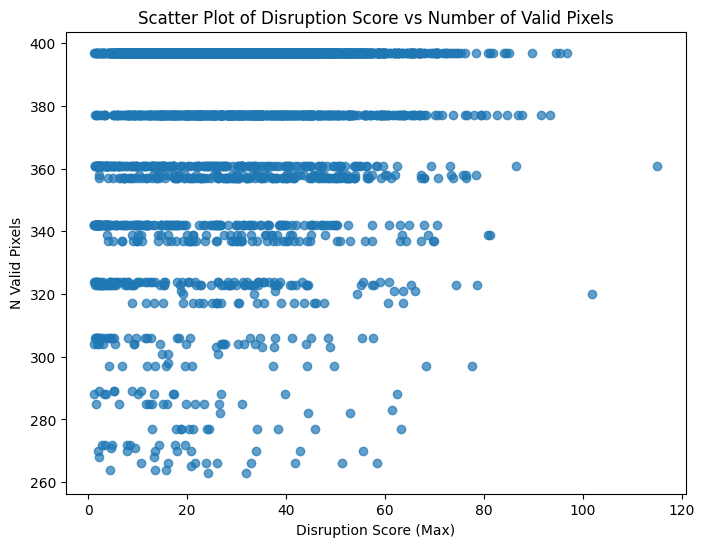

In [21]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_overlapped_df["SCD_h1_m0_t1"], mean_ins["n_valid_pixels_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('Disruption Score (Max)')
plt.ylabel('N Valid Pixels')
plt.title('Scatter Plot of Disruption Score vs Number of Valid Pixels')

# Show the plot
plt.show()

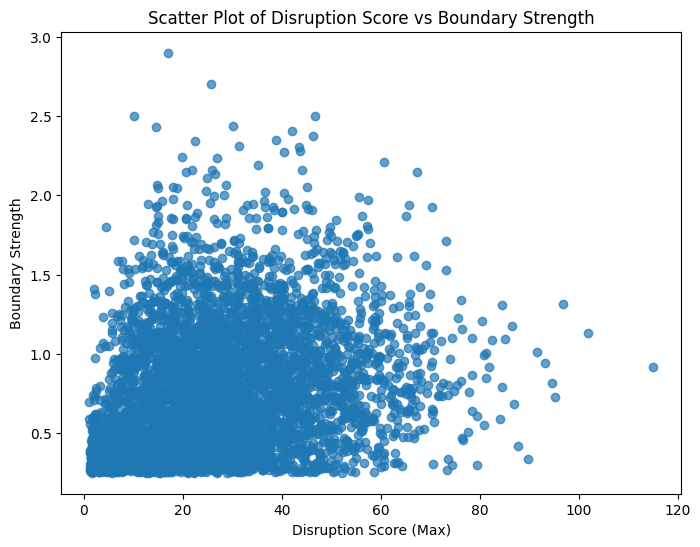

In [22]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_overlapped_df["SCD_h1_m0_t1"], mean_ins["boundary_strength_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('Disruption Score (Max)')
plt.ylabel('Boundary Strength')
plt.title('Scatter Plot of Disruption Score vs Boundary Strength')

# Show the plot
plt.show()

### Splitting TAD boundaries as explained and unexplained

In [23]:
# +-28kb
sensitive_types = [f"down{i}" for i in range(12,0,-1)] + [f"tad{i}" for i in range(1,6)] + [f"up{i}" for i in range(1,13)]
centered_df = df[df['type'].isin(sensitive_types)].reset_index(drop=True)

idx = centered_df.groupby(['chrom', 'start', 'end'])['SCD_h1_m0_t1'].idxmax()
result_df = df.loc[idx].reset_index(drop=True)

thresholds_li = threshold_li(result_df['SCD_h1_m0_t1'].values.astype('float32'))

In [24]:
# Li threshold differentiating disruption-sensitive from disruption-resilient boundaries
thresholds_li

18.705717

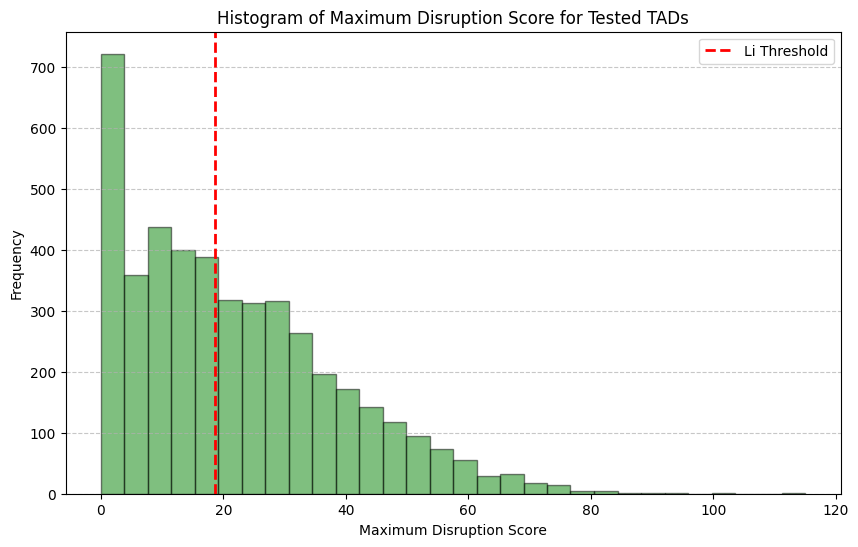

In [25]:
# Assuming explained_tads and unexplained_tads DataFrames have a column 'miss_per'
plt.figure(figsize=(10, 6))

# Plotting the histogram for explained_tads
plt.hist(result_df['SCD_h1_m0_t1'], bins=30, alpha=0.5, color='green', edgecolor='black')

# thresholds_li = threshold_li(result_df['SCD_h1_m0_t1'].values)

plt.axvline(thresholds_li, color='red', linestyle='dashed', linewidth=2, label='Li Threshold')

# # Adding labels and title
plt.xlabel('Maximum Disruption Score')
plt.ylabel('Frequency')
plt.title('Histogram of Maximum Disruption Score for Tested TADs')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.savefig("./plots/max_disruption_threshold.pdf", format="pdf")

# Show the plot
plt.show()

In [26]:
sensitive_tads = result_df[result_df['SCD_h1_m0_t1'] >= thresholds_li]
resilient_tads = result_df[result_df['SCD_h1_m0_t1'] < thresholds_li]

In [27]:
perc = round((len(sensitive_tads) / len(result_df)) * 100, 3)
print("Number of disruption-sensitive TAD boundaries:", len(sensitive_tads))
print(f"This is {perc}% of all the tested mouse boundaries.")

Number of disruption-sensitive TAD boundaries: 2211
This is 49.419% of all the tested mouse boundaries.


In [28]:
perc = round((len(resilient_tads) / len(result_df)) * 100, 3)
print("Number of disruption-resilient TAD boundaries:", len(resilient_tads))
print(f"This is {perc}% of all the tested mouse boundaries.")

Number of disruption-resilient TAD boundaries: 2263
This is 50.581% of all the tested mouse boundaries.


In [29]:
sensitive_tads_around_ins_minimum = sensitive_tads[sensitive_tads["type"].isin(["tad1", "tad2", "tad3", "tad4", "tad5"])]
sensitive_tads_off_ins_minimum = sensitive_tads[~sensitive_tads["type"].isin(["tad1", "tad2", "tad3", "tad4", "tad5"])]

In [30]:
perc = round((len(sensitive_tads_around_ins_minimum) / len(result_df)) * 100, 3)
print("Number of disruption-sensitive TAD boundaries overlapping INS-16 minimum:", len(sensitive_tads_around_ins_minimum))
print(f"This is {perc}% of all the tested mouse boundaries.")

Number of disruption-sensitive TAD boundaries overlapping INS-16 minimum: 270
This is 6.035% of all the tested mouse boundaries.


In [31]:
perc = round((len(sensitive_tads_off_ins_minimum) / len(result_df)) * 100, 3)
print("Number of disruption-sensitive TAD boundaries non-overlapping INS-16 minimum:", len(sensitive_tads_off_ins_minimum))
print(f"This is {perc}% of all the tested mouse boundaries.")

Number of disruption-sensitive TAD boundaries non-overlapping INS-16 minimum: 1941
This is 43.384% of all the tested mouse boundaries.


In [32]:
print("Number of disruption-sensitive TAD boundaries with maximum downstream from the INS-16 minimum:", len(sensitive_tads[sensitive_tads["type"].isin([f"down{i}" for i in range(12,0,-1)])]))
print("Number of disruption-sensitive TAD boundaries with maximum upstream from the INS-16 minimum:", len(sensitive_tads[sensitive_tads["type"].isin([f"up{i}" for i in range(1,13)])]))

Number of disruption-sensitive TAD boundaries with maximum downstream from the INS-16 minimum: 1032
Number of disruption-sensitive TAD boundaries with maximum upstream from the INS-16 minimum: 905


In [ ]:
# sensitive_tads.to_csv("./../results/disruption_sensitive_boundaries.tsv", sep="\t", index=False)
# resilient_tads.to_csv("./../results/disruption_resilient_boundaries.tsv", sep="\t", index=False)